# Predicting Heart Disease with Adaboost (Based off of a Decision Tree Classifier)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import plotly.tools as tls


In [4]:
df = pd.read_csv('heart_disease.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          293 non-null object
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(12), object(1)
memory usage: 33.2+ KB


###### age: age in years
###### sex(1 = male; 0 = female)
###### cp : chest pain type ( 0-2 states different types of angina and  3 means no chest pain )
###### trestbps : resting blood pressure (in mm Hg on admission to the hospital)
###### chol : serum cholestoral in mg/dl
###### fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
###### restec : gresting electrocardiographic results
###### thalach : maximum heart rate achieved
###### exang : exercise induced angina (1 = yes; 0 = no)
###### oldpeak : ST depression induced by exercise relative to rest
###### slope : the slope of the peak exercise ST segment
###### ca : number of major vessels (0-3) colored by flourosopy
###### thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
###### target: 1 or 

In [6]:
df.isnull().sum()

age          0
sex          0
cp          10
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64

In [7]:
# We have null values in iur dataset, which we need to handle

/Users/eddie/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



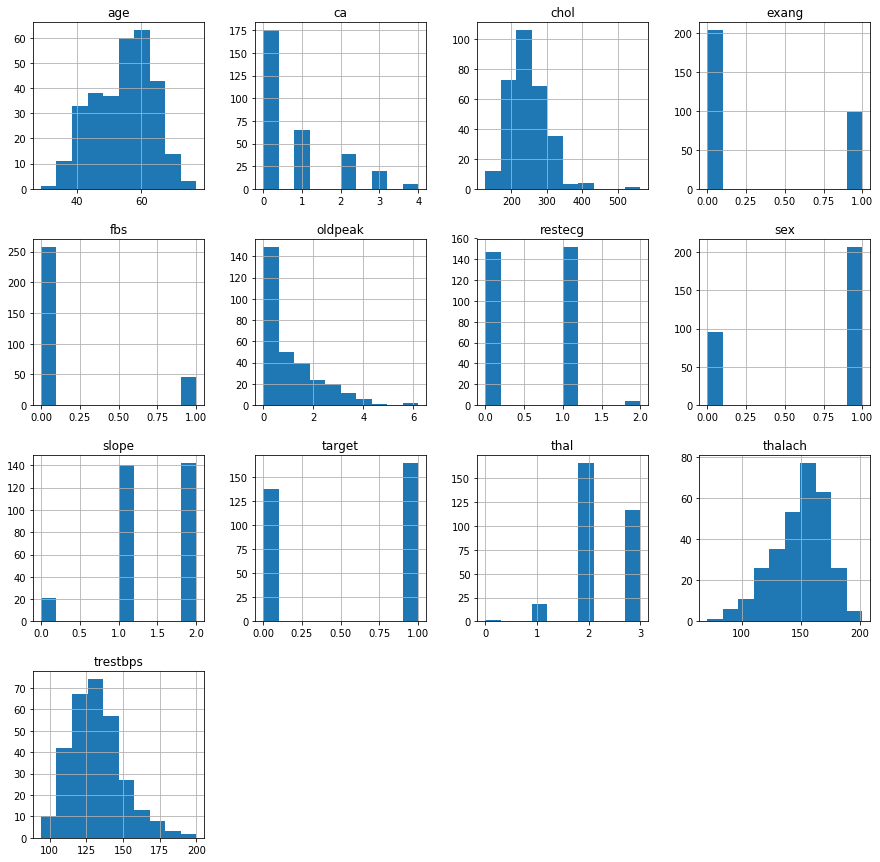

In [8]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

In [9]:
df.describe()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


##### As the coulmn cp (chest pain) has missing values, we need to impute the data. 

###### The data is numeric and hence mean stratergy will be a suitable choice.

In [10]:
from sklearn.preprocessing import Imputer
imput = Imputer(missing_values='NaN',strategy='mean')
df = list(imput.fit_transform(df))

for i in range(303):
    for j in range(14):
        df[i][j] = math.ceil(df[i][j])

/Users/eddie/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.



In [11]:
df = pd.DataFrame(df)

In [12]:
df=df.rename(columns={0: 'age', 1:'sex', 2:'cp', 3:'trestbps',4: 'chol',5: 'fbs',6: 'restecg',7: 'thalach',8: 'exang',9: 'oldpeak',10: 'slope',11: 'ca',12: 'thal',13:'target'})

In [19]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,0.0,150.0,0.0,3.0,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,4.0,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,2.0,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,1.0,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,1.0,2.0,0.0,2.0,1.0
5,57.0,1.0,0.0,140.0,192.0,0.0,1.0,148.0,0.0,1.0,1.0,0.0,1.0,1.0
6,56.0,0.0,1.0,140.0,294.0,0.0,0.0,153.0,0.0,2.0,1.0,0.0,2.0,1.0
7,44.0,1.0,1.0,120.0,263.0,0.0,1.0,173.0,0.0,0.0,2.0,0.0,3.0,1.0
8,52.0,1.0,2.0,172.0,199.0,1.0,1.0,162.0,0.0,1.0,2.0,0.0,3.0,1.0
9,57.0,1.0,2.0,150.0,168.0,0.0,1.0,174.0,0.0,2.0,2.0,0.0,2.0,1.0


In [13]:
# Let's find out the most important features in the dataset that will play a major role in predicting the class label

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
x = df.iloc[:,:-1]

In [16]:
y = df.iloc[:,-1]

In [17]:
model= RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(x,y)
pd.Series(model.feature_importances_,index=x.columns).sort_values(ascending=False)

thal        0.127732
ca          0.117530
thalach     0.115284
cp          0.114049
age         0.092933
chol        0.086188
trestbps    0.079302
oldpeak     0.072846
exang       0.065039
slope       0.062542
sex         0.036971
restecg     0.019255
fbs         0.010329
dtype: float64

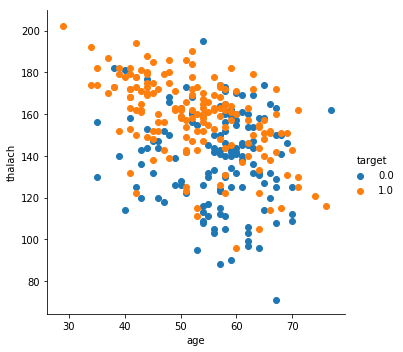

In [18]:
sns.FacetGrid(df, hue="target", height=5) \
   .map(plt.scatter, "age", "thalach") \
   .add_legend()
plt.show()

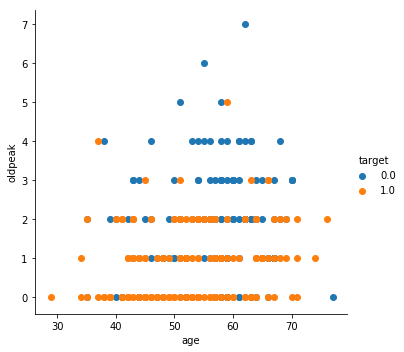

In [20]:
sns.FacetGrid(df, hue="target", height=5) \
   .map(plt.scatter, "age", "oldpeak") \
   .add_legend()
plt.show()

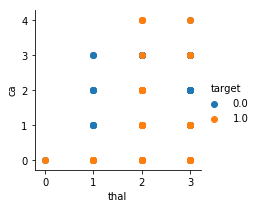

In [21]:
sns.FacetGrid(df, hue="target", height=3) \
   .map(plt.scatter, "thal", "ca") \
   .add_legend()
plt.show()

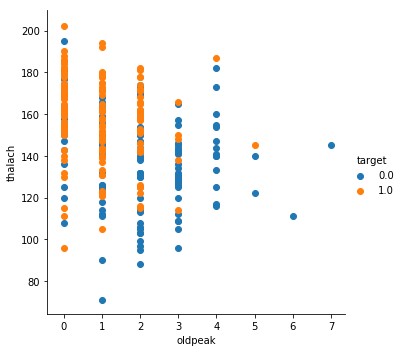

In [23]:
sns.FacetGrid(df, hue="target", height=5) \
   .map(plt.scatter, "oldpeak", "thalach") \
   .add_legend()
plt.show()

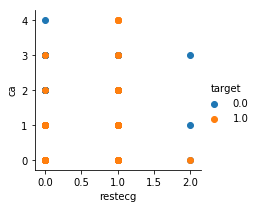

In [24]:
sns.FacetGrid(df, hue="target", height=3) \
   .map(plt.scatter, "restecg", "ca") \
   .add_legend()
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [58]:
# For 'cp' column, it records chest pain type. Number 3 mean no chest pain, number 0-2 means different tyoe of angina. 

# To simplify it, I will group the number 0-2 together as disease positive, number 3 as disease negative

In [26]:
number=[0,1,2]
for col in df.itertuples():

    if col.cp in number:
        df['cp'].replace(to_replace=col.cp, value=1, inplace=True)

## Testing the accuracy when the top 8 features are used for fitting

In [27]:
df_top8 = df.loc[:,['cp','oldpeak','thal','ca','thalach','age','chol','trestbps','exang']]

In [29]:
x_train,x_test,y_train,y_test = train_test_split(df_top8,y,test_size=0.25,random_state=0)
clf = AdaBoostClassifier()
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)
accuracy = accuracy_score(prediction,y_test)

# Confusion matrix is the amount of misclassfied in each group
# The diagonal is the correctly classified elements
# When target = 0, 26 are correctly classified and 6 elements are misclassfied
# When target = 1, 37 are correctly classified and 6 elements are misclassified
cm = confusion_matrix(prediction,y_test)


prfs = precision_recall_fscore_support(prediction,y_test)
print('Accuracy: ',accuracy)
print('\n')
print('Confusion Matrix: \n',cm)
print('\n')
print('Precision: ', prfs[0])
print('Recall:    ', prfs[1])
print('Fscore:    ', prfs[2])
print('Support:   ', prfs[3])

Accuracy:  0.8289473684210527


Confusion Matrix: 
 [[26  6]
 [ 7 37]]


Precision:  [0.78787879 0.86046512]
Recall:     [0.8125     0.84090909]
Fscore:     [0.8        0.85057471]
Support:    [32 44]


## Maybe, Standardization could hep ?

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
x = df.iloc[:,:-1]
x_std = StandardScaler().fit_transform(x)

In [28]:
x_train,x_test,y_train,y_test = train_test_split(x_std,y,test_size=0.25,random_state=0)
clf = AdaBoostClassifier()
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)
accuracy = accuracy_score(prediction,y_test)
cm = confusion_matrix(prediction,y_test)
prfs = precision_recall_fscore_support(prediction,y_test)
print('Accuracy: ',accuracy)
print('\n')
print('Confusion Matrix: ',cm)
print('\n')
print('Precision: ', prfs[0])
print('Recall:    ', prfs[1])
print('Fscore:    ', prfs[2])
print('Support:   ', prfs[3])

Accuracy:  0.8421052631578947


Confusion Matrix:  [[28  7]
 [ 5 36]]


Precision:  [0.84848485 0.8372093 ]
Recall:     [0.8        0.87804878]
Fscore:     [0.82352941 0.85714286]
Support:    [35 41]


In [29]:
# Not much of a difference using Standardization


### Accuracy with different test sizes

In [34]:
testSize = [0.5,0.4,0.3,0.25,0.2,0.15,0.1]

acc = []
for i in testSize:
    x_train,x_test,y_train,y_test = train_test_split(x_std,y,test_size=i)
    clf = AdaBoostClassifier()
    clf.fit(x_train,y_train)
    prediction=clf.predict(x_test)
    acc.append(accuracy_score(prediction,y_test))

models_dataframe=pd.DataFrame(acc,index=testSize)   
models_dataframe

,0
0.50,0.796053
0.40,0.778689
0.30,0.791209
0.25,0.802632
0.20,0.852459
0.15,0.847826
0.10,0.709677


### We can conclude that training size in the range 70% to 75% gives the optimal result, otherwise the data faces the issues of either under fitting or over fitting